In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('fivethirtyeight')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
pd.options.mode.chained_assignment = None

# Any results you write to the current directory are saved as output.

/kaggle/input/nfl-data-up-to-week-12/Week12NFLData.csv


In the Preseason the Chicago Bears were heralded as playoff favorites and Super Bowl Contenders. 12 Weeks into the season the Bears are 5-7, technically in the hunt but ESPN predicts them to have a 1% chance of making it in. Throughout the Offseason, fans heard that the offense was taking steps into the '202' progression of plays and most expected a big jump from 2018 considering they were average in almost every statistical category. This report investigates the inner workings of the Chicago Bears offense. 

Expected Points Added is used to add more value to the limited nature of yards gained by adding field position and down & distance. 

Gaining three yards on  2nd down and 10, and gaining three yards on 4th down and 3, will both register as +3 in yards gained. But, the three yards gained with three yards to go is more valuable than the three yards gained with 10 yards to go, because it creates a first down and keeps the chains moving. The same principle applies with field position. Taking a sack in general is bad but taking one in your own terriotory vs taking one in field goal range are different and should be reflected in statistics. A loss of 10 on your 35 is graded differently than a loss of 10 on your opponents 35 using EPA. 

Calculating EPA is used from next points scored for total plays. As the points are added up for and against the offensive team, the differential point advantage can be found for any down and distance.
![](http://)

Datafiles are provided by NflscrapR. 

![](http://https://www.chicagobears.com/)

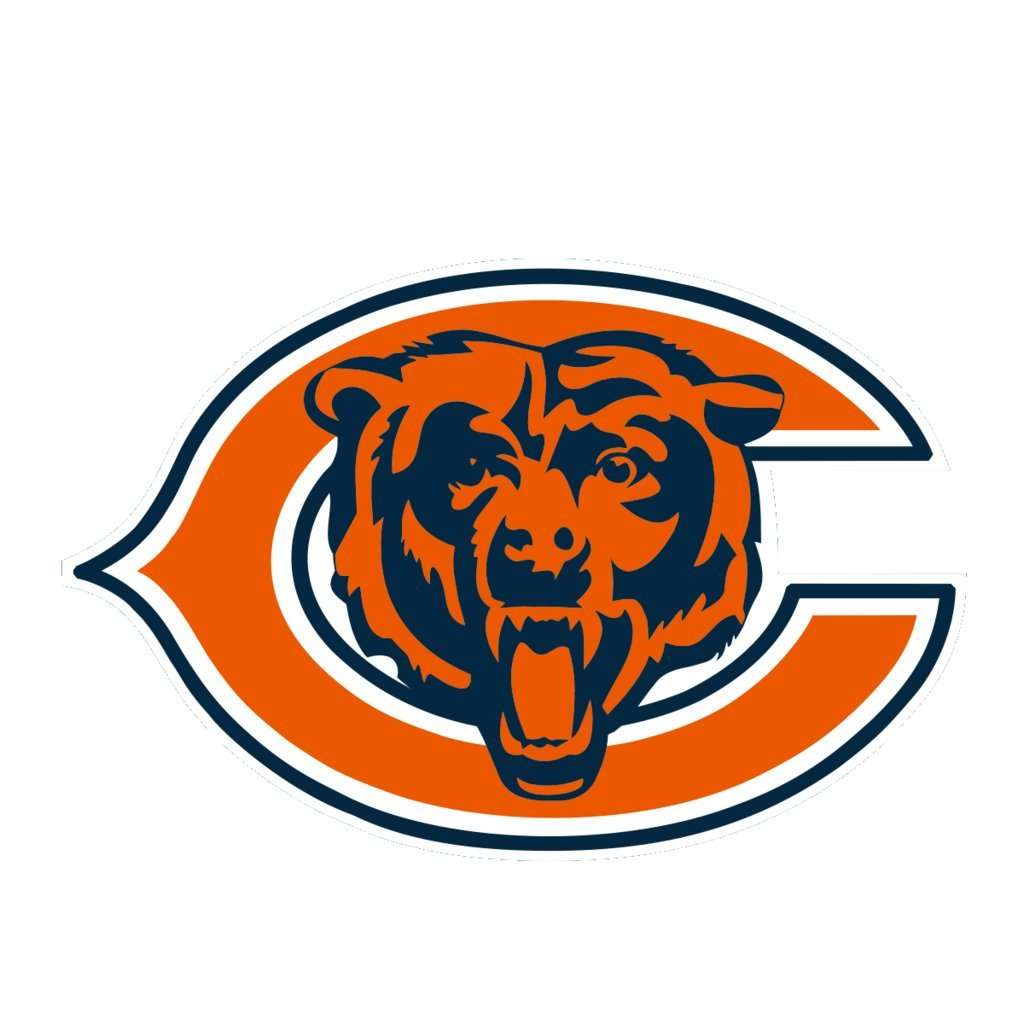


In [2]:
import pandas as pd
data = pd.read_csv("../input/nfl-data-up-to-week-12/Week12NFLData.csv")

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (42,167,168,191,192,227,228,240) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = data.loc[(data.play_type.isin(['pass','run', 'no_play'])) &
               data.epa.isna()==False]

Creating a dataframe with Run, Pass and NoPlays (that are penalties). 

In [4]:
data[data['play_type'] =='no_play']

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
5,155,2019090500,CHI,GB,CHI,home,GB,CHI,57.0,9/5/19,...,00-0033120,K.Clark,5.0,0,NaN,Defensive Holding,0.0,0.0,0.0,0.0
30,846,2019090500,CHI,GB,CHI,home,GB,CHI,95.0,9/5/19,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
31,863,2019090500,CHI,GB,CHI,home,GB,CHI,90.0,9/5/19,...,00-0024061,T.Williams,6.0,0,NaN,Defensive Pass Interference,0.0,0.0,0.0,0.0
61,1686,2019090500,CHI,GB,CHI,home,GB,CHI,73.0,9/5/19,...,00-0030441,K.Long,10.0,0,NaN,Offensive Holding,0.0,0.0,0.0,0.0
73,1981,2019090500,CHI,GB,GB,away,CHI,CHI,46.0,9/5/19,...,00-0023459,A.Rodgers,5.0,0,NaN,False Start,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31297,2823,2019112500,LA,BAL,BAL,away,LA,LA,38.0,11/25/19,...,0,NaN,5.0,0,NaN,Defensive Too Many Men on Field,0.0,0.0,0.0,0.0
31298,2850,2019112500,LA,BAL,BAL,away,LA,LA,38.0,11/25/19,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
31312,3156,2019112500,LA,BAL,LA,home,BAL,BAL,47.0,11/25/19,...,00-0027866,E.Thomas III,5.0,0,NaN,Illegal Contact,0.0,0.0,0.0,0.0
31327,3551,2019112500,LA,BAL,BAL,away,LA,LA,12.0,11/25/19,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [5]:
data.loc[data.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

data.loc[data.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'
data.reset_index(drop = True, inplace = True)

Searching the "description" column in the data to find plays that contain a position or "scramble" or "sacked" to included in runs and passes respectively. 

In [6]:
#Create a smaller dataframe with plays where rusher_player_name is null
rusher_nan = data.loc[(data['play_type'] == 'run') &
         (data['rusher_player_name'].isnull())]
         
#Create a list of the indexes/indices for the plays where rusher_player_name is null
rusher_nan_indices = list(rusher_nan.index)

for i in rusher_nan_indices:
    #Split the description on the blank spaces, isolating each word
    desc = data['desc'].iloc[i].split()
    #For each word in the play description
    for j in range(0,len(desc)):
        #If a word is right, up, or left
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            #Set rusher_player_name for that play to the word just before the direction
            data['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass
#Create a smaller dataframe with plays where passer_player_name is null
passer_nan = data.loc[(data['play_type'] == 'pass') &
         (data['passer_player_name'].isnull())]
#Create a list of the indexes/indices for the plays where passer_player_name is null
passer_nan_indices = list(passer_nan.index)

for i in passer_nan_indices:
    #Split the description on the blank spaces, isolating each word
    desc = data['desc'].iloc[i].split()
    #For each word in the play description
    for j in range(0,len(desc)):
        #If a word is pass
        if desc[j] == 'pass':
            data['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass
#Change any backwards passes that incorrectly labeled passer_player_name as Backward
data.loc[data['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')

receiver_nan = data.loc[(data['play_type'] == 'pass') & 
                        (data['receiver_player_name'].isnull()) &
                        (data['desc'].str.contains('scrambles|sacked|incomplete')==False)]

receiver_nan_indices = list(receiver_nan.index)

for i in receiver_nan_indices:
    desc = data['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j] != desc[-1]):
            if desc[j+1]=='to':
                data['receiver_player_name'].iloc[i] = desc[j+2]
        else:
            pass

In [7]:
data.loc[data['epa'] > 0, 'success'] = 1

In [8]:
bears_stats = data.loc[data['posteam'] == 'CHI']
bears_stats

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,success
5,155,2019090500,CHI,GB,CHI,home,GB,CHI,57.0,9/5/19,...,K.Clark,5.0,0,NaN,Defensive Holding,0.0,0.0,0.0,0.0,1.0
6,195,2019090500,CHI,GB,CHI,home,GB,CHI,52.0,9/5/19,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1.0
7,216,2019090500,CHI,GB,CHI,home,GB,GB,47.0,9/5/19,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,NaN
8,238,2019090500,CHI,GB,CHI,home,GB,GB,47.0,9/5/19,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1.0
9,260,2019090500,CHI,GB,CHI,home,GB,GB,40.0,9/5/19,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29295,4260,2019112402,CHI,NYG,CHI,home,NYG,CHI,66.0,11/24/19,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,NaN
29296,4277,2019112402,CHI,NYG,CHI,home,NYG,CHI,67.0,11/24/19,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1.0
29306,4517,2019112402,CHI,NYG,CHI,home,NYG,NYG,35.0,11/24/19,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,NaN
29307,4538,2019112402,CHI,NYG,CHI,home,NYG,NYG,36.0,11/24/19,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,NaN


Loading only the Chicago Bears Data

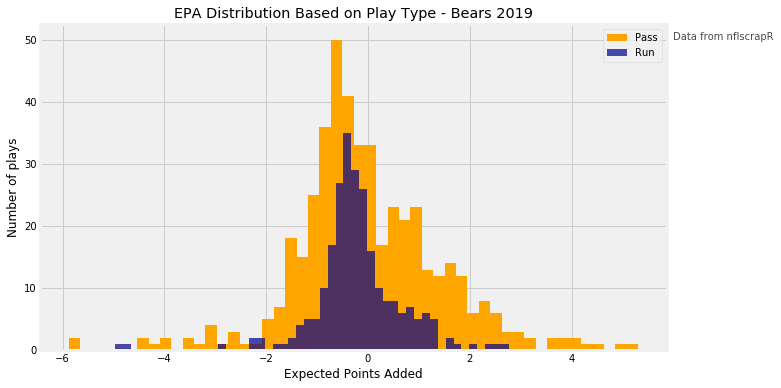

In [9]:
plt.figure(1, figsize = (10,6))
plt.hist(bears_stats['epa'].loc[bears_stats['play_type'] == 'pass'], bins = 50, label = 'Pass', color = 'orange')
plt.hist(bears_stats['epa'].loc[bears_stats['play_type'] == 'run'], bins = 50, label = 'Run', alpha = .7, color = 'darkblue')
plt.xlabel('Expected Points Added')
plt.ylabel('Number of plays')
plt.title('EPA Distribution Based on Play Type - Bears 2019')
plt.text(6,50,'Data from nflscrapR', fontsize=10, alpha=.7)
#Will show the colors and labels of each histogram
plt.legend()
plt.show()

Distribution of EPA on Runs vs Pass plays. As we can see the Bears have more runs than passes and they seem to be more spread and slightly more successful. Running the ball has been a struggle for the Bears all season, injuries on the Offensive Line and regression from older players appear to be the biggest factors. According the Pro-Football Reference the Bears rank 20th in passing and 26th in rushing. 

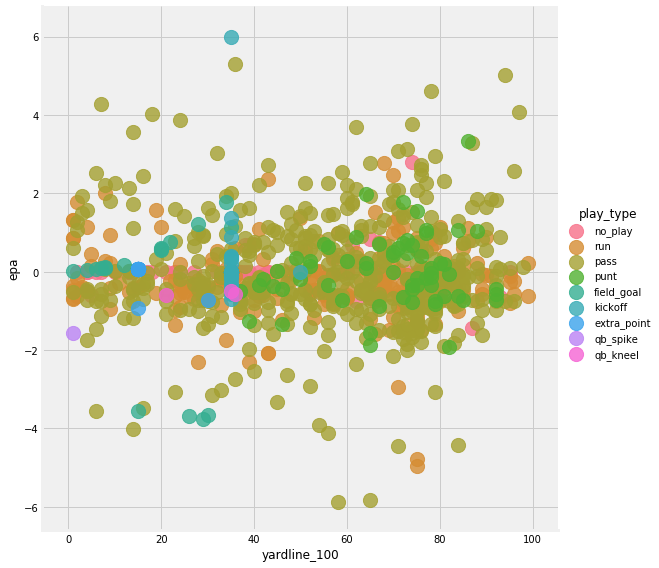

In [10]:
sns.lmplot(data = bears_stats, x = 'yardline_100', y = 'epa', 
                  fit_reg = False, hue = 'play_type',
                    height = 8, 
                  scatter_kws = {'s':200})
plt.show()

Looking at play distribution by where the Bears are on the field. Typically the closer to 0 (opposing teams goalline) teams should have high EPA rushing plays since that is the easiest way to score. But the Bears have a wide range of passing results and average rushing results. 

In [11]:
selected_column = ['pass_length', 'pass_location', 'run_location', 'run_gap', 'play_type']
for c in selected_column:
    print(bears_stats[c].value_counts(normalize=True).to_frame(), '\n')

       pass_length
short     0.818653
deep      0.181347 

        pass_location
right        0.432642
left         0.318653
middle       0.248705 

        run_location
right          0.436
left           0.416
middle         0.148 

         run_gap
guard   0.408451
tackle  0.300469
end     0.291080 

             play_type
pass          0.491909
run           0.266451
no_play       0.076591
punt          0.069040
kickoff       0.048544
extra_point   0.021575
field_goal    0.020496
qb_kneel      0.004315
qb_spike      0.001079 



The Bears are a predominantly short passing team, preferring checkdowns over coverage beaters. Most passes going to the Quarterback's right which is similar to all NFL QB's since most are right handed. The Bears also are a horizontal rushing team, running to the Right and Left at similar clips but avoiding the middle. Passing calls of nearly ~50% is high, most NFL Coordinators prefer a 50/50 game and the league average currently is 60/40.

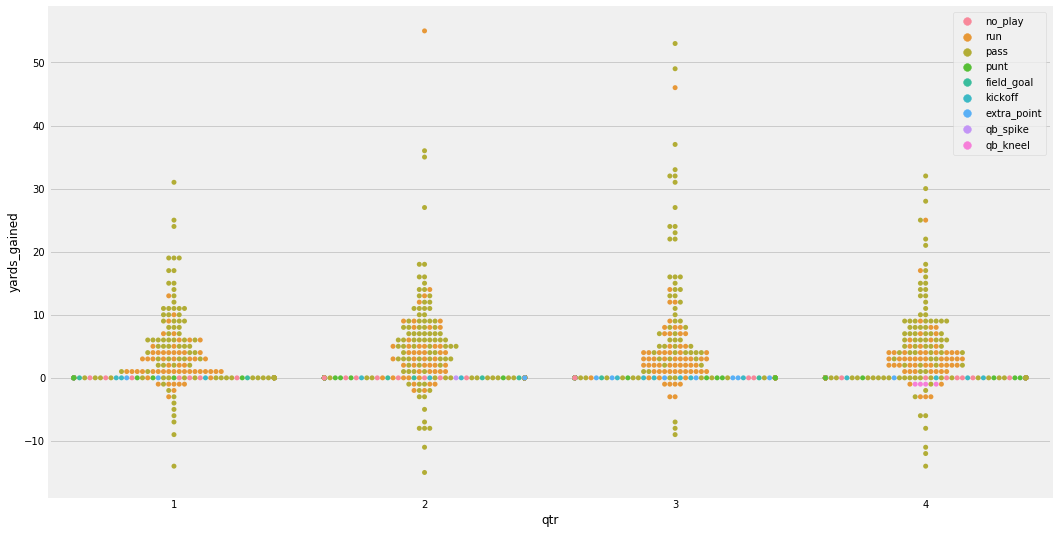

In [12]:
plt.figure(figsize=(16,9))
sns.swarmplot(x= bears_stats['qtr'],
              y = bears_stats['yards_gained'],
              hue = bears_stats['play_type'])
plt.legend(loc='upper right')
plt.show()

The Bears offense in the first half has been abysmal this season, setting several records for longest time without touchdowns and points scored this season. But they gain more yards in the 3rd quarter through the ground and the air.

In [13]:
nfcnorth = data.loc[(data['posteam']== 'CHI') | (data['posteam']== 'DET') | 
                   (data['posteam']== 'GB') | (data['posteam']== 'MIN')]

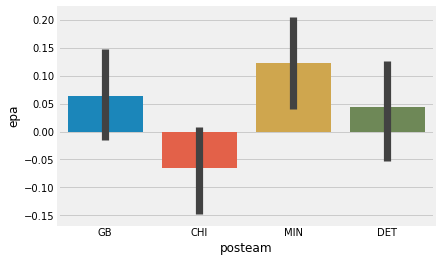

In [14]:
sns.barplot( x = 'posteam', y = 'epa', data = nfcnorth)

Comparing the Bears EPA to their divisional rivals.

In [15]:
nfl_wrs = data.loc[(data['play_type']=='pass') & (data['down']<=4)].groupby(by='receiver_player_name')[['epa','success','yards_gained', 'td_prob', 'air_yards', 'yardline_100','qtr', 'yac_epa']].mean()

In [16]:
bears_wrs = data.loc[(data['posteam']=='CHI') & (data['play_type']=='pass') & (data['down']<=4)].groupby(by='receiver_player_name')[['epa','success','yards_gained', 'td_prob', 'air_yards', 'yardline_100','qtr', 'yac_epa']].mean()

In [17]:
#Add new column
nfl_wrs['attempts'] = data.loc[(data['play_type']=='pass') & 
                        (data['down']<=4)].groupby(by='receiver_player_name')['epa'].count()

#Sort by mean epa
nfl_wrs.sort_values('epa', ascending=False, inplace=True)

#Filter by attempts
nfl_wrs = nfl_wrs.loc[nfl_wrs['attempts'] > 10] 

#
bears_wrs['attempts'] = data.loc[(data['posteam']=='CHI') & (data['play_type']=='pass') & 
                        (data['down']<=4)].groupby(by='receiver_player_name')['epa'].count()

#Sort by mean epa
bears_wrs.sort_values('epa', ascending=False, inplace=True)

#Filter by attempts
bears_wrs = bears_wrs.loc[bears_wrs['attempts'] > 10] 


Specifically looking at the NFL and Bears WRs epa

In [18]:
bears_wrs

,epa,success,yards_gained,td_prob,air_yards,yardline_100,qtr,yac_epa,attempts
receiver_player_name,,,,,,,,,
A.Robinson,0.341603,1.0,7.717172,0.308929,10.520833,58.404040,2.575758,-0.451544,99
B.Braunecker,0.298986,1.0,5.363636,0.313194,10.090909,52.909091,1.909091,-0.517200,11
T.Gabriel,0.285927,1.0,7.204082,0.332468,11.583333,58.673469,2.530612,-0.675874,49
A.Miller,0.159668,1.0,6.980000,0.304858,10.120000,56.420000,2.680000,-0.798821,50
A.Shaheen,0.064529,1.0,5.692308,0.396198,3.769231,43.000000,2.461538,-0.043810,13
J.Wims,-0.103794,1.0,5.785714,0.325168,13.000000,49.714286,2.928571,-0.962004,14
D.Montgomery,-0.110497,1.0,5.366667,0.319026,3.066667,60.700000,2.466667,0.426410,30
T.Cohen,-0.157505,1.0,3.835616,0.303577,2.528571,56.301370,2.452055,0.122952,73
C.Patterson,-0.216745,1.0,3.545455,0.370410,4.272727,42.636364,2.272727,-0.828389,11


Chart with all of the Bears WRs going over the epa, success (whether epa is greater than 0 or not), yards gained, probability of scoring a touchdown on that play, air yards gained, distance to opposing teams endzone, quarter, yards after catch epa.

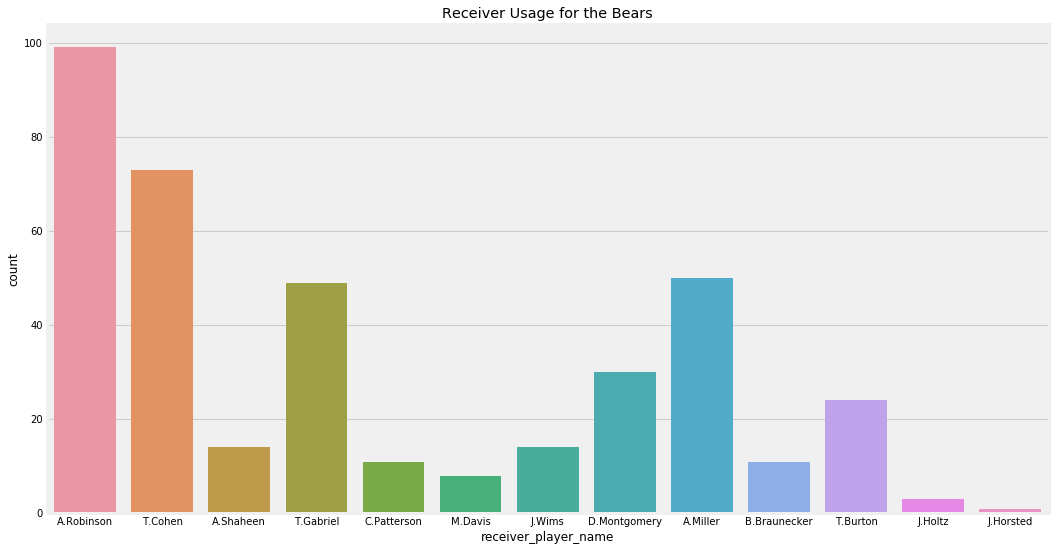

In [19]:
plt.figure(figsize=(16,9))
plt.title('Receiver Usage for the Bears')
sns.countplot(bears_stats['receiver_player_name'])

Counting the amount of attempts aka 'passing plays involved' the Bears receiving core had. Allen Robinson and Tarik Cohen are by far the Bears highest usage players. While Taylor Gabriel has had injuries this season holding his attempts down and 2nd year Anthony Miller is still figuring out the offense so isnt being used as frequently. The Tight Ends has been a troubled position all season with Burton, Holtz, Horsted, Braunecker and Shaheen all rotating. Shaheen and Burton were put on IR this week so the others should get a boost in attempts in coming weeks. 

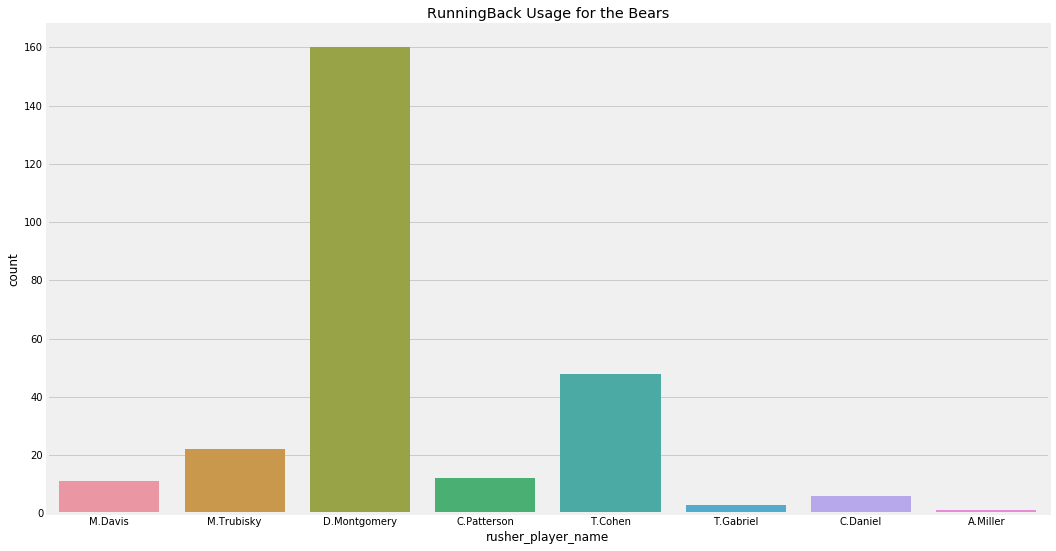

In [20]:
plt.figure(figsize=(16,9))
plt.title('RunningBack Usage for the Bears')
sns.countplot(bears_stats['rusher_player_name'])

Looking at the running backs rookie Montgomery is the clear #1 back with Cohen filling in for a change of pace. FA signee Davis barely got used through 12 weeks.  Along with the Bears using WRs on occasion for trick run plays. 

In [21]:
wr_table = pd.pivot_table(bears_stats, index = ['receiver_player_name'],
               columns = ['defteam'],
               values = ['epa'], aggfunc = [np.mean], fill_value = 0)        
wr_table

mean                                          \
                           epa                                           
defteam                    DEN       DET        GB        LA       LAC   
receiver_player_name                                                     
A.Miller             -0.123056 -0.000056 -0.234842 -0.039057  3.015513   
A.Robinson           -0.089057  0.571166  0.284555 -0.409969  0.507257   
A.Shaheen             0.712912  0.000000 -0.192100  0.000000 -1.137014   
B.Braunecker          0.000994  4.021766  0.000000 -0.227462  0.000000   
C.Patterson           0.000000  0.000000 -0.904592  0.000000 -0.464155   
D.Montgomery         -0.434040  0.000000  1.890707 -0.830838 -0.276161   
J.Holtz               0.000000  0.000000  0.000000  0.000000  0.000000   
J.Horsted             0.000000  0.000000  0.000000  0.000000  0.000000   
J.Wims                0.000000  0.000000 -0.685453 -0.198191  0.000000   
M.Davis               0.000000  0.000000 -0.320052  0.000000  2.133475   
T.Burton             -0.418245 -1.339976  0.000000  0.000000 -1.407913   
T.Cohen              -0.515447 -0.492156 -0.061190  0.485982  0.080214   
T.Gabriel             0.271908  0.186613 -0.346995 -0.274537  0.792090   

                                                                        \
                                                                         
defteam                    MIN        NO       NYG       OAK       PHI   
receiver_player_name                                                     
A.Miller              0.548111  0.116399 -0.215744 -0.157011 -0.282724   
A.Robinson            0.804296  0.383364  0.728156  0.707471 -0.880579   
A.Shaheen             0.555308  0.830881  0.000000  0.000000 -1.405118   
B.Braunecker          0.000000  0.000000 -0.013380  0.000000  0.000000   
C.Patterson          -0.275926  0.466591  0.000000  0.000000 -0.139151   
D.Montgomery         -0.230478  0.177684 -0.402710  2.471293 -0.223141   
J.Holtz               0.079949  0.000000  0.000000  0.588742  0.000000   
J.Horsted             0.000000  0.000000  0.023865  0.000000  0.000000   
J.Wims                0.369448  2.521342 -2.454566 -0.299308  0.000000   
M.Davis               0.000000  0.000000  0.000000  0.000000  0.000000   
T.Burton              0.073297 -0.016769  0.000000  0.402728 -0.572063   
T.Cohen              -0.182591 -0.444199 -0.226707 -0.129571 -0.461038   
T.Gabriel             0.000000 -0.737014  0.156212  0.000000  1.836134   

                                
                                
defteam                    WAS  
receiver_player_name            
A.Miller              0.118683  
A.Robinson            0.294029  
A.Shaheen             0.213219  
B.Braunecker          0.000000  
C.Patterson           0.273193  
D.Montgomery          0.132083  
J.Holtz               0.000000  
J.Horsted             0.000000  
J.Wims                1.154027  
M.Davis               0.000000  
T.Burton              0.022729  
T.Cohen               0.516661  
T.Gabriel             1.288125

Looking at all the Bears WRs EPA by Game this season. 

<Figure size 1152x648 with 0 Axes>

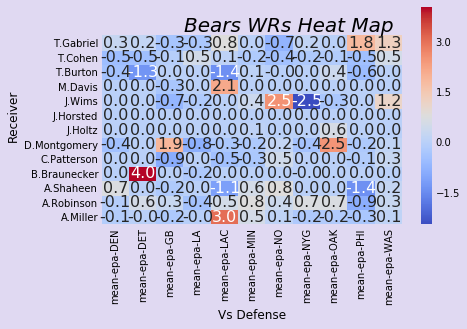

In [22]:
plt.figure(figsize=(16,9))
plt.rcParams['font.size'] = 10
bg_color = (0.88,0.85,0.95)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color
fig, ax = plt.subplots(1)
p = sns.heatmap(wr_table,
                cmap='coolwarm',
                annot=True,
                fmt=".1f",
                annot_kws={'size':16},
                ax=ax)
plt.xlabel('Vs Defense')
plt.ylabel('Receiver')
ax.set_ylim((0,15))
plt.text(3,13.3, "Bears WRs Heat Map", fontsize = 20, color='Black', fontstyle='italic')
plt.show()

Heat map of who was playing well vs the Bears opponents this season. A few standout games from Montgomery, Miller, Wims and Braunecker. With Robinson and Gabriel having consistently positive EPA and Miller showing flashes but remains rocky with his production. But even these players are producing average EPA, for the offense to play better they have to make more plays. 

In [23]:
bears_rbs_pivot = pd.pivot_table(bears_stats,
            index = ['rusher_player_name'],
            columns = ['run_location'],
            values = ['epa'], 
            aggfunc = [np.mean],
            fill_value = 0)

<Figure size 1152x648 with 0 Axes>

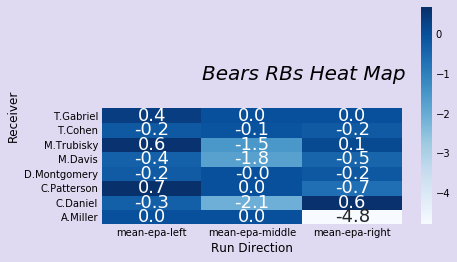

In [24]:
plt.figure(figsize=(16,9))
plt.rcParams['font.size'] = 10
bg_color = (0.88,0.85,0.95)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color
fig, ax = plt.subplots(1)
p = sns.heatmap(bears_rbs_pivot,
                cmap='Blues',
                annot=True,
                fmt=".1f",
                annot_kws={'size':18},
                ax=ax)
plt.xlabel('Run Direction')
plt.ylabel('Receiver')
ax.set_ylim((0,15))
plt.text(1,10, "Bears RBs Heat Map", fontsize = 20, color='Black', fontstyle='italic')
plt.show()

The rushing attack is not good with most players means being around 0. But from this set Montgomery is consistently solid running and Tarik is slightly hurting the rushing attack. QB Trubisky is positive rushing to his left. While using WRs for "trick" plays has generally been unsuccessful when ran with Anthony Miller but running with Gabriel and Patterson to the left has shown a slight uptick in EPA. 

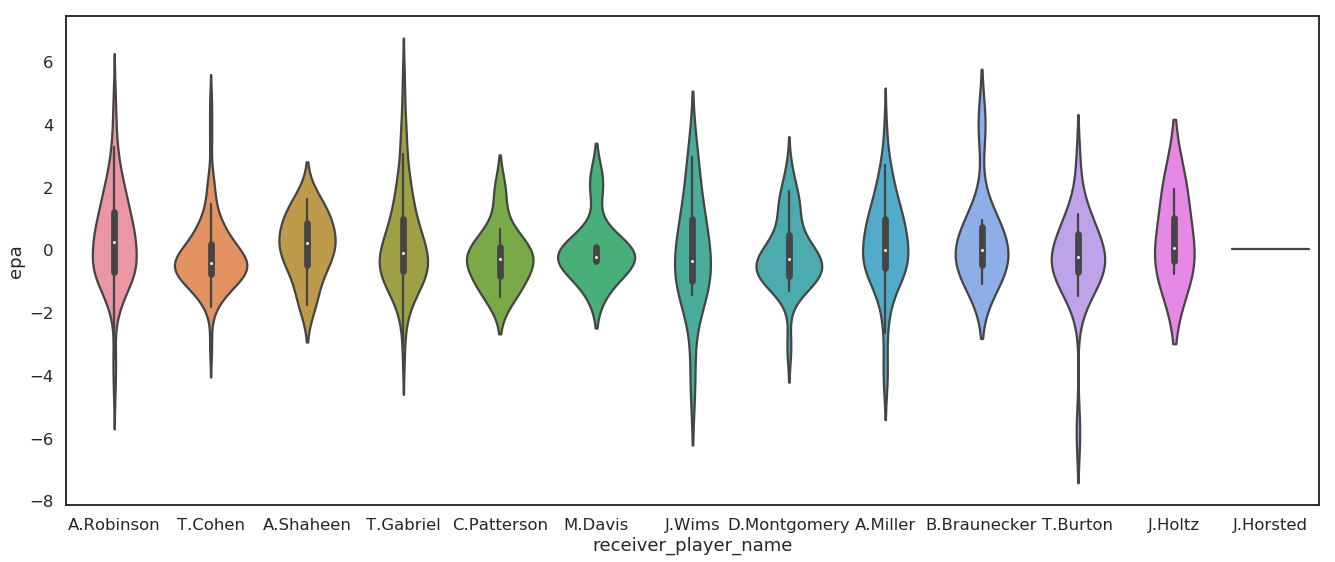

In [25]:
sns.set(style="white", context="talk")
plt.figure(figsize=(20,9))
sns.violinplot(data = data[data.posteam =='CHI'],
                   x ='receiver_player_name', y = 'epa')
plt.show()

In [26]:
bears_wrs.epa.mean()

0.025912046935477336

In [27]:
nfl_wrs.epa.mean()

0.15306669003314832

Bears WRs are performing below the NFL average at EPA. Biggest indicator of this is dropped passes which the Bears lead the NFL in. 

<Figure size 1152x648 with 0 Axes>

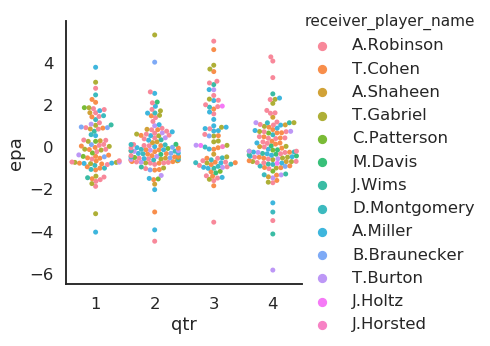

In [28]:
plt.figure(figsize=(16,9))
sns.set(style="white", context="talk")
sns.catplot(x="qtr", y='epa', hue="receiver_player_name", kind="swarm", data=bears_stats);
plt.show()

Conclusions: The Bears offense looks to be stalling in 2019 for multiple reasons. 

The plays being called are skewed heavily towards pass, which can make it easier for the opposing team to defend. But when runs are called they are largely unsuccessful and not adding to the net EPA. 

This hinderance can be further explained by looking at the production from the Bears skill positions specifically the receiving core. Except for Allen Robinson none are performing close to the league average and it appears by having several receivers with middling attemps the coaching staff is unsure of who they can get production out of.

The QB was ignored in this report due to the dozens of analysis on him already available, examining the players and play calls around him seemed prudent given the teams record. 